### Code for generation of Figure 7
_Integrative analysis of cell state changes in lung fibrosis with peripheral protein biomarkers'_ 
in EMBO Molecular Medicine. <br> 
Christoph H. Mayr, Lukas M. Simon, Gabriela Leuschner, et al. and Fabian J. Theis, Herbert Schiller

In [1]:
## This Notebook is based on the anndata object generated in integrate_munich_chicago_nashville_cohorts.ipynb
## raw counts for additional Chicago and Nashville Patients were obtained from 2 recent publications 
## Chicago (Reyfman PA et al, 2018) and Nashville (Habermann AC et al, 2019)

import scanpy as sc
import bbknn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sb
import matplotlib.patches as mpatches

import warnings
warnings.filterwarnings("ignore")

import matplotlib.colors as colors
gray_red = colors.LinearSegmentedColormap.from_list("grouping", ["lightgray", "red", "darkred"], N = 128)

plt.rcParams['figure.figsize'] = (6, 5)
folder = "~/20200210_Schiller_humanILD_meshal.ansari/"

sc.settings.verbosity = 3
sc.logging.print_version_and_date()

Running Scanpy 1.6.1.dev110+gb4234d81, on 2021-02-11 13:40.


### Define Functions used in this Notebook

In [2]:
def plot_gene_corr(means, cors, corr_gene = "CFHR1", norbmt = None, top = 50):
    cors = cors[cors.pvalue < 0.01].copy()
    genes = cors.index.values
    
    if norbmt:
        ## Exclude ribosomal / mitochondrial genes from differential gene expression table
        rbmt_genes = [name for name in genes if name.startswith('RP') | name.startswith('MT-') | name.startswith('RPL')| name.startswith('RPS')]
        cors = cors[~cors.index.isin(rbmt_genes)]

    ## Exclude correlation gene from list to plot
    top = int(top/2)
    genes = np.concatenate((cors.index.values[1:(top + 1)], cors.index.values[-top:]))
    corr_gene_expr = means.loc[:, corr_gene].T.copy()
    corr_gene_expr.sort_values(inplace = True)

    means_plot = means.loc[:, genes].T
    means_plot = means_plot.loc[:, corr_gene_expr.index.values]
    print(means_plot.shape)
    
    %R -i corr_gene names(gene_col) <- corr_gene    
    %R -i genes -i corr_gene_expr -i means_plot -i top anno_row <- data.frame(sign = c(rep("pos", top), rep("neg", top)))
    %R rownames(anno_row) <- genes
    %R anno_col <- data.frame(gene = corr_gene_expr)
    %R colnames(anno_col) <- corr_gene
    %R rownames(anno_col) <- colnames(means_plot)

    %R -w 800 -h 800 p <- pheatmap(means_plot, scale = 'row', cluster_cols = F, show_colnames = F, \
                                                 col = color, annotation_row = anno_row, annotation_col = anno_col, \
                                                 breaks = seq(-2, 2, length = 100), annotation_colors = gene_col, \
                                                 main = paste("Correlation to", corr_gene))

def get_expr_table(adata, xlabel = "overcluster"):
    genExp = pd.DataFrame(adata.raw.X.todense(), index = adata.obs_names, columns = adata.raw.var_names)
    genExp[xlabel] = adata.obs[xlabel]
    
    ## Mean expression per cluster
    meanExp = genExp.groupby(["overcluster"]).mean().reset_index()
    meanExp.set_index("overcluster", inplace = True)
    return meanExp

def get_percentage(a, genes, groups, thresh = 0, use_raw = False):
    genedf = sc.get.obs_df(a, keys=[*groups, *genes], use_raw = use_raw)
    grouped = genedf.groupby(groups, observed = True)
    
    exp = grouped.agg(lambda x: np.nanmean(x[x > thresh])).fillna(0)
    percent = grouped.agg(lambda x: np.mean(x > thresh)).fillna(0).T
    percent.columns = ["Pct.expressed %s" %c for c in percent.columns]
    return percent    

def correlate_means_to_gene(means, corr_gene = "EOMES"):
    import scipy.stats
    genes = means.columns.values
    cors = pd.DataFrame(index = genes, columns = ["spearman_corr", "pvalue"])
    tab = means.loc[:, [corr_gene]].values

    for gene in genes:
        tmp = scipy.stats.spearmanr(tab, means.loc[:, [gene]])   # Spearman's rho    
        cors.loc[gene, :] = tmp[0:2]
    cors.dropna(axis = 0, inplace = True)
    cors.sort_values("spearman_corr", ascending = False, inplace = True)
    
    return cors

def get_scaled_meanExp(genes, adata, xlabel = "dpt_pseudotime"):
    use_raw = False if adata.raw is None else True
    genExp = sc.get.obs_df(adata, keys = genes + [xlabel], layer = None, use_raw = use_raw)

    ## Bin the DPT values and calculate mean expression per bin
    genExp["dpt_bins"] = np.digitize(genExp.dpt_pseudotime, np.arange(0, 1, 0.1))
    mean_dpt = pd.DataFrame(columns = genes)
    mean_dpt["dpt_bins"] = [i for i in range(1, 11)]

    for gene in genes:
        mean_dpt[gene] = genExp.groupby(["dpt_bins"])[gene].mean().reset_index()[gene]
        mean_dpt[gene] = np.interp(mean_dpt[gene], (mean_dpt[gene].min(), mean_dpt[gene].max()), (0, +1))
    return mean_dpt

def lineplot_scaled_meanExp(mean_dpt, cols, xlabel = "dpt_bins", figsize = (10, 6)):
    patches = []
    fig, ax = plt.subplots(figsize = figsize)
    
    for i, gene in enumerate(mean_dpt.columns.values[:-1]):
        cat = sb.regplot(data = mean_dpt, x = xlabel, y = gene, scatter = False, order = 3, truncate = True,
                         ax = ax, color = cols[i], ci = 0)
        patches.append(mpatches.Patch(color = cols[i], label = gene))
    
    cat.set_ylabel("expression", size = 15)
    cat.set_xlabel("pseudotime", size = 15)
    sb.despine()
    plt.legend(handles = patches, loc = "center left", bbox_to_anchor=(1.02, 0.5),
               prop = {"size": 10}, frameon = False)
    plt.show()

### Read in Data Object

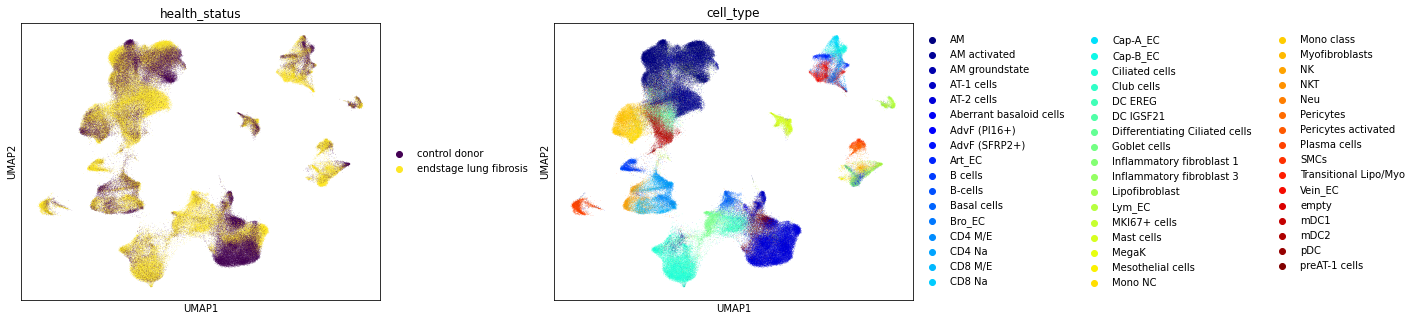

In [3]:
adata = sc.read(folder + "integrated_human_dataset.h5ad")
sc.pl.umap(adata, color = ["health_status", "cell_type"], wspace = 0.35)

... storing 'data_set' as categorical


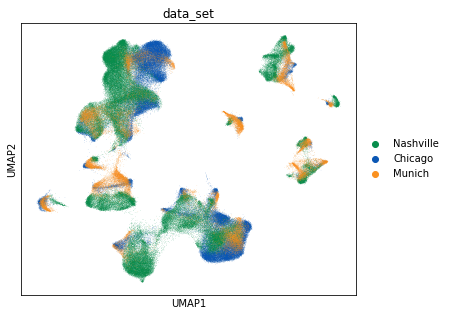

In [4]:
adata.obs["data_set"] = ["Munich" if p.startswith("muc") else "Chicago" if p.startswith("GS")
                         else "Nashville" for p in adata.obs.patient_id]
sc._utils.sanitize_anndata(adata)
adata.obs.data_set.cat.reorder_categories(["Nashville", "Chicago", "Munich"], inplace = True)
sc.pl.umap(adata, color = ["data_set"], wspace = 0.35)

### Generate Pericyte Subset

In [5]:
pericytes = adata[adata.obs["cell_type"].isin(["Pericytes","Pericytes activated"])].copy()

## Only keep patients with at least 10 Pericyte cells
tab = pericytes.obs.patient_id.value_counts().reset_index()
tab.columns = ["patient_id", "nr_cells"]
pericytes = pericytes[pericytes.obs.patient_id.isin(tab[tab.nr_cells > 10].patient_id.values)].copy()
pericytes.shape

(1782, 38615)

### Run Differential Gene Expression with Diffxpy
https://github.com/theislab/diffxpy

In [6]:
import diffxpy.api as de

## Make snapshot object of raw counts (stored in .X)
pericytes_raw = pericytes.copy()
sc.pp.filter_genes(pericytes_raw, min_cells = 75)
pericytes_raw.obs["n_counts_scaled"] = pericytes_raw.obs["n_counts"] / pericytes_raw.obs["n_counts"].mean()

filtered out 32351 genes that are detected in less than 75 cells


In [7]:
de_test = de.test.wald(data = pericytes_raw.X, 
                       formula_loc = "~ 1 + health_status",
                       factor_loc_totest = "health_status",
                       gene_names = pericytes_raw.var_names, sample_description = pericytes_raw.obs,
                       noise_model = "nb", size_factors = "n_counts_scaled")

training location model: True
training scale model: True
iter   0: ll=57615258.590078
caught 98 linalg singular matrix errors
iter   1: ll=57115509.764192, converged: 0.00% (loc: 22.64%, scale update: False), in 3.95sec
iter   2: ll=57053656.935188, converged: 0.00% (loc: 22.64%, scale update: False), in 2.87sec
iter   3: ll=57052584.434336, converged: 0.00% (loc: 22.64%, scale update: False), in 2.82sec
iter   4: ll=57052583.703467, converged: 0.00% (loc: 22.81%, scale update: False), in 2.77sec
iter   5: ll=57052583.702283, converged: 0.00% (loc: 79.95%, scale update: False), in 2.87sec
iter   6: ll=5442274.569488, converged: 0.00% (loc: 0.00%, scale update: True), in 29.47sec
caught 98 linalg singular matrix errors
iter   7: ll=5401187.344035, converged: 0.00% (loc: 7.98%, scale update: False), in 3.08sec
iter   8: ll=5397149.106336, converged: 0.00% (loc: 18.45%, scale update: False), in 3.09sec
iter   9: ll=5397091.986824, converged: 0.00% (loc: 73.02%, scale update: False), in 2.

In [10]:
## Convert Result to Table
res = de_test.summary().sort_values(by = ["qval"], ascending = True).loc[:, ["gene", "pval", "qval", "log2fc"]]
res = res.merge(get_percentage(pericytes_raw, genes = res.gene.values, groups = ["health_status"]),
                left_on = "gene", right_index = True)

## Save Table
## res.to_csv(folder + "diffxpy_pericytes_ILD_vs_healthy.txt", sep = "\t")

### Calculate Gene Correlation to SSTR2 within pericytes

In [11]:
from rpy2.robjects import pandas2ri
pandas2ri.activate()
%load_ext rpy2.ipython

In [12]:
%%R
library(pheatmap)
library(grid)

## Set colours
color = colorRampPalette(c("deepskyblue3", "white", "red3"))(100)
gene_col = list(gene = c("white", "red3"))

In [14]:
sc.tl.louvain(pericytes, resolution = 2.5, key_added = "overcluster")
meanExp = get_expr_table(pericytes, xlabel = "overcluster")

corr_gene = "SSTR2"
cors = correlate_means_to_gene(meanExp, corr_gene = corr_gene)

## Save Mean Expression and Correlation Results
# meanExp.to_csv(folder + "SSTR2_meanExp.txt", sep = "\t")
# cors.to_csv(folder + "SSTR2_correlation.txt", sep = "\t")

cors.head(10)

,spearman_corr,pvalue
SSTR2,1,0
YAP1,0.921798,1.23461e-22
GOLGA3,0.830295,1.49503e-14
SNAI1,0.783586,4.0246e-12
DCP1A,0.768629,1.81728e-11
PPP1R15B,0.762987,3.1179e-11
CFH,0.759721,4.23283e-11
SLC25A25,0.759524,4.31095e-11
TP53BP1,0.750426,9.84776e-11
CXCL2,0.744793,1.61393e-10


#### Fig 7 e) Expression of genes most strongly associated with SSTR2 expression within the pericytes

(74, 53)


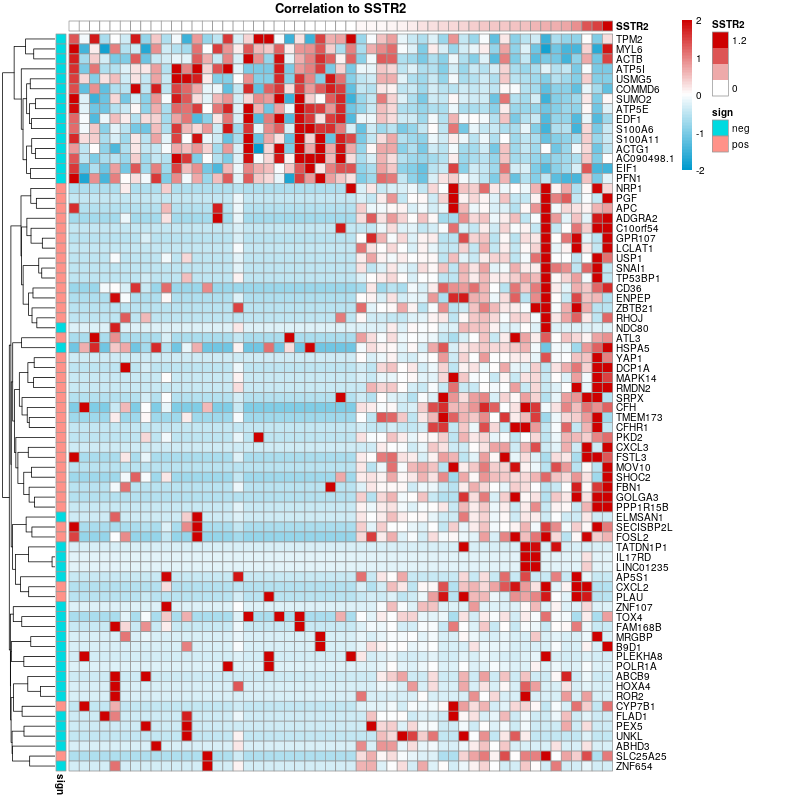

In [16]:
plot_gene_corr(meanExp, cors, corr_gene = corr_gene, norbmt = True, top = 75)

### Pericyte Trajectory in only ILD Patients

In [17]:
## Original Parameters for diffmap Calculation
# pericytes = pericytes[pericytes.obs.health_status == "endstage lung fibrosis"].copy()
# pericytes.var["highly_variable"]["MALAT1"] = False
# sc.pp.pca(pericytes, n_comps = 30)
# bbknn.bbknn(pericytes, neighbors_within_batch = 3, n_pcs = 30, batch_key = "data_set")
# sc.tl.diffmap(pericytes)

# root_id = np.arange(pericytes.n_obs)[np.argmax(pericytes.obsm["X_diffmap"][:, 1])]
# pericytes.uns["iroot"] = root_id
# sc.tl.dpt(pericytes, n_branchings = 1, n_dcs = 10)

## Set Coordinates based on meta file to be consistend with figures
pericytes = pericytes[pericytes.obs.health_status == "endstage lung fibrosis"].copy()
pericyte_meta = pd.read_csv(folder + "pericytes_ILD_metadata.txt", sep = "\t", index_col = 0)
pericytes.obsm["X_diffmap"] = pericyte_meta.loc[:, ["dc_0", "dc_1", "dc_2", "dc_3"]].values

pericytes.obs["dpt_pseudotime"] = np.nan
pericytes.obs.update(pericyte_meta.dpt_pseudotime)

#### Figure 7 k) Diffusion map of pericytes colored by cell type and inferred pseudotime

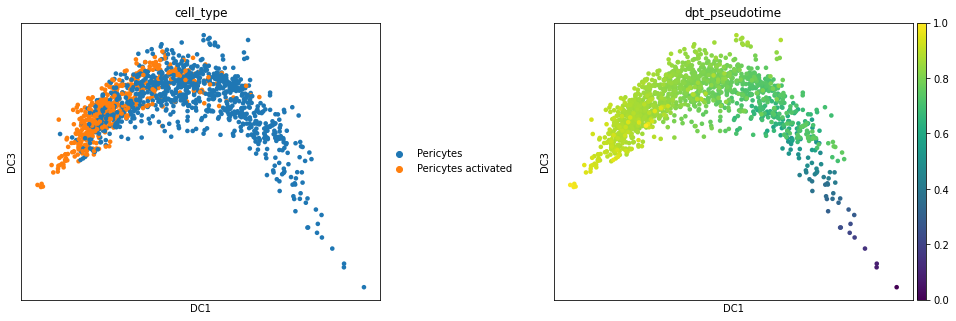

In [18]:
pericytes.uns["cell_type_colors"] = ["tab:blue", "tab:orange"]
sc.pl.diffmap(pericytes, color = ["cell_type", "dpt_pseudotime"], components = "1,3", wspace = 0.35)

#### Figure 7 l) Diffusion map of pericytes colored by the gene expression of indicated genes

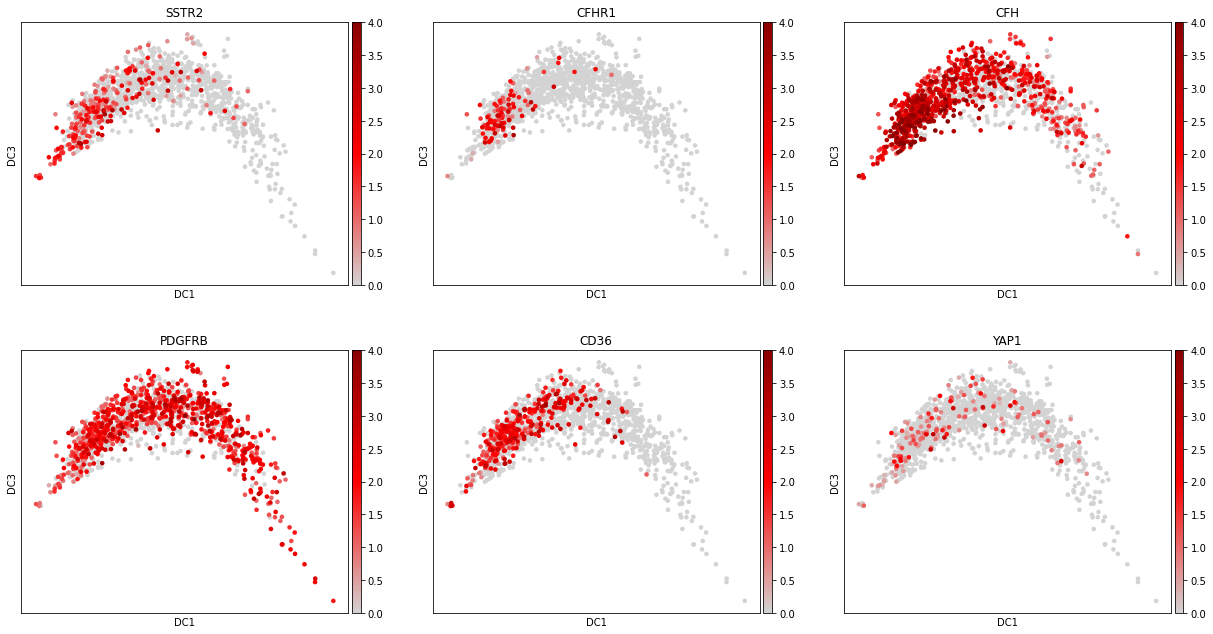

In [19]:
genes = ["SSTR2", "CFHR1", "CFH", "PDGFRB", "CD36", "YAP1"]
sc.pl.diffmap(pericytes, color = genes, cmap = gray_red, components = "1,3", ncols = 3, vmax = 4)

#### Figure 7 m) Scaled expression levels across the pericyte pseudotime differentiation trajectory

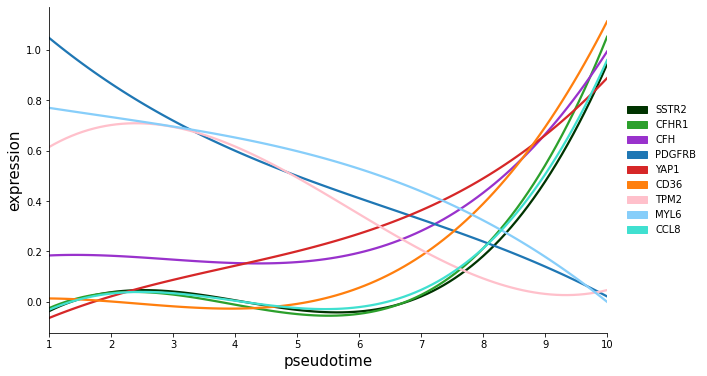

In [21]:
genes = ["SSTR2","CFHR1","CFH","PDGFRB","YAP1","CD36","TPM2","MYL6","CCL8"]
cols = ["#003300", "tab:green", "darkorchid", "tab:blue", "tab:red", "tab:orange", "pink",
        "lightskyblue", "turquoise","brown"]

mean_dpt = get_scaled_meanExp(genes, pericytes, xlabel = "dpt_pseudotime")
lineplot_scaled_meanExp(mean_dpt, cols = cols, xlabel = "dpt_bins", figsize = (10, 6))